In [120]:
!pip install statsmodels
!pip install imblearn

In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optuna
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    accuracy_score,
)
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from catboost import *
import gc

import warnings
warnings.filterwarnings('ignore')

In [122]:
class CFG:
    TARGET = 'loan_status'
    N_FOLDS = 5
    RANDOM_STATE = 410

    TRAIN_PATH = './Data/train.csv'
    TEST_PATH = './Data/test.csv'
    SUBMIT_PATH = './Data/sample_submission.csv'
    ORIGINAL_PATH = './Data/credit_risk_dataset.csv'

In [123]:
class DataAnalysis:

    @staticmethod
    def info_df(df: pd.DataFrame):
        print('------------------------------')
        print('| Dataset information |')
        print('------------------------------')
        df.info()
        print('-----------------------------------------')
        print('| First 5 rows |')
        print('-----------------------------------------')
        display(df.head())
        print('--------------------')
        print('| Sum of duplicates |')
        print('--------------------')
        print(df.duplicated().sum())


    @staticmethod
    def view_distribution(data: pd.DataFrame, object_col = False, numeric_col = False):
        numeric_cols = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()
        object_cols = data.select_dtypes(include=['object']).columns.to_list()
        
        if numeric_col:
            fig, axes = plt.subplots(nrows=len(data[numeric_cols].columns), ncols=2, figsize=(len(numeric_cols)+15,len(numeric_cols)+7))
            j = 0
            for i in data[numeric_cols].columns:
                sns.histplot(data[numeric_cols][i], ax=axes[j, 0], kde=True, bins=40, edgecolor='black')
                axes[j, 0].set_title(i, fontsize=14)
                axes[j, 0].set_xlabel('')

                sns.boxplot(x=data[numeric_cols][i], ax=axes[j, 1], orient='h', palette='pink')
                axes[j, 1].set_title(i, fontsize=14)
                axes[j, 1].set_xlabel('')
                j += 1
            plt.suptitle(f'Num features\n\n', ha='center', fontweight='bold', fontsize=20);
            plt.tight_layout();
            plt.show();

        if object_col:
            _,ax = plt.subplots(len(object_cols),1, figsize=(len(object_cols)+7,len(object_cols)+20));
            ax =ax.flatten();
            g = 0
            for k in data[object_cols].columns:
                sns.countplot(data=data, x=k,ax=ax[g]);
                ax[g].set_xticklabels(labels=ax[g].get_xticklabels());
                ax[g].set_title(k);
                ax[g].set_xlabel('');
                g += 1
            plt.suptitle(f'Categorical\n\n', ha='center', fontweight='bold', fontsize=20);
            plt.show();


    @staticmethod
    def bloating_of_variance(data: pd.DataFrame):
        num = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()
        vif_data = pd.DataFrame()
        vif_data['feature'] = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()

        # вычисление VIF для каждого признака
        vif_data['VIF'] = [variance_inflation_factor(data[num].values, i) \
                                for i in range(len(data[num].columns))]
        print(vif_data)

In [124]:
train_competitions = pd.read_csv(CFG.TRAIN_PATH, index_col='id')
train_original = pd.read_csv(CFG.ORIGINAL_PATH)
test_competitions = pd.read_csv(CFG.TEST_PATH, index_col='id')

submission = pd.read_csv(CFG.SUBMIT_PATH)

In [125]:
for data in [train_competitions, train_original]:
    DataAnalysis.info_df(data)

------------------------------
| Dataset information |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes:

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


--------------------
| Sum of duplicates |
--------------------
0
------------------------------
| Dataset information |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


--------------------
| Sum of duplicates |
--------------------
165


In [126]:
train_original['person_emp_length'] = train_original['person_emp_length'].fillna(train_original['person_emp_length'].median())
train_original['loan_int_rate'] = train_original['loan_int_rate'].fillna(train_original['loan_int_rate'].mean())

In [127]:
train_original = train_original.drop_duplicates().reset_index(drop=True)

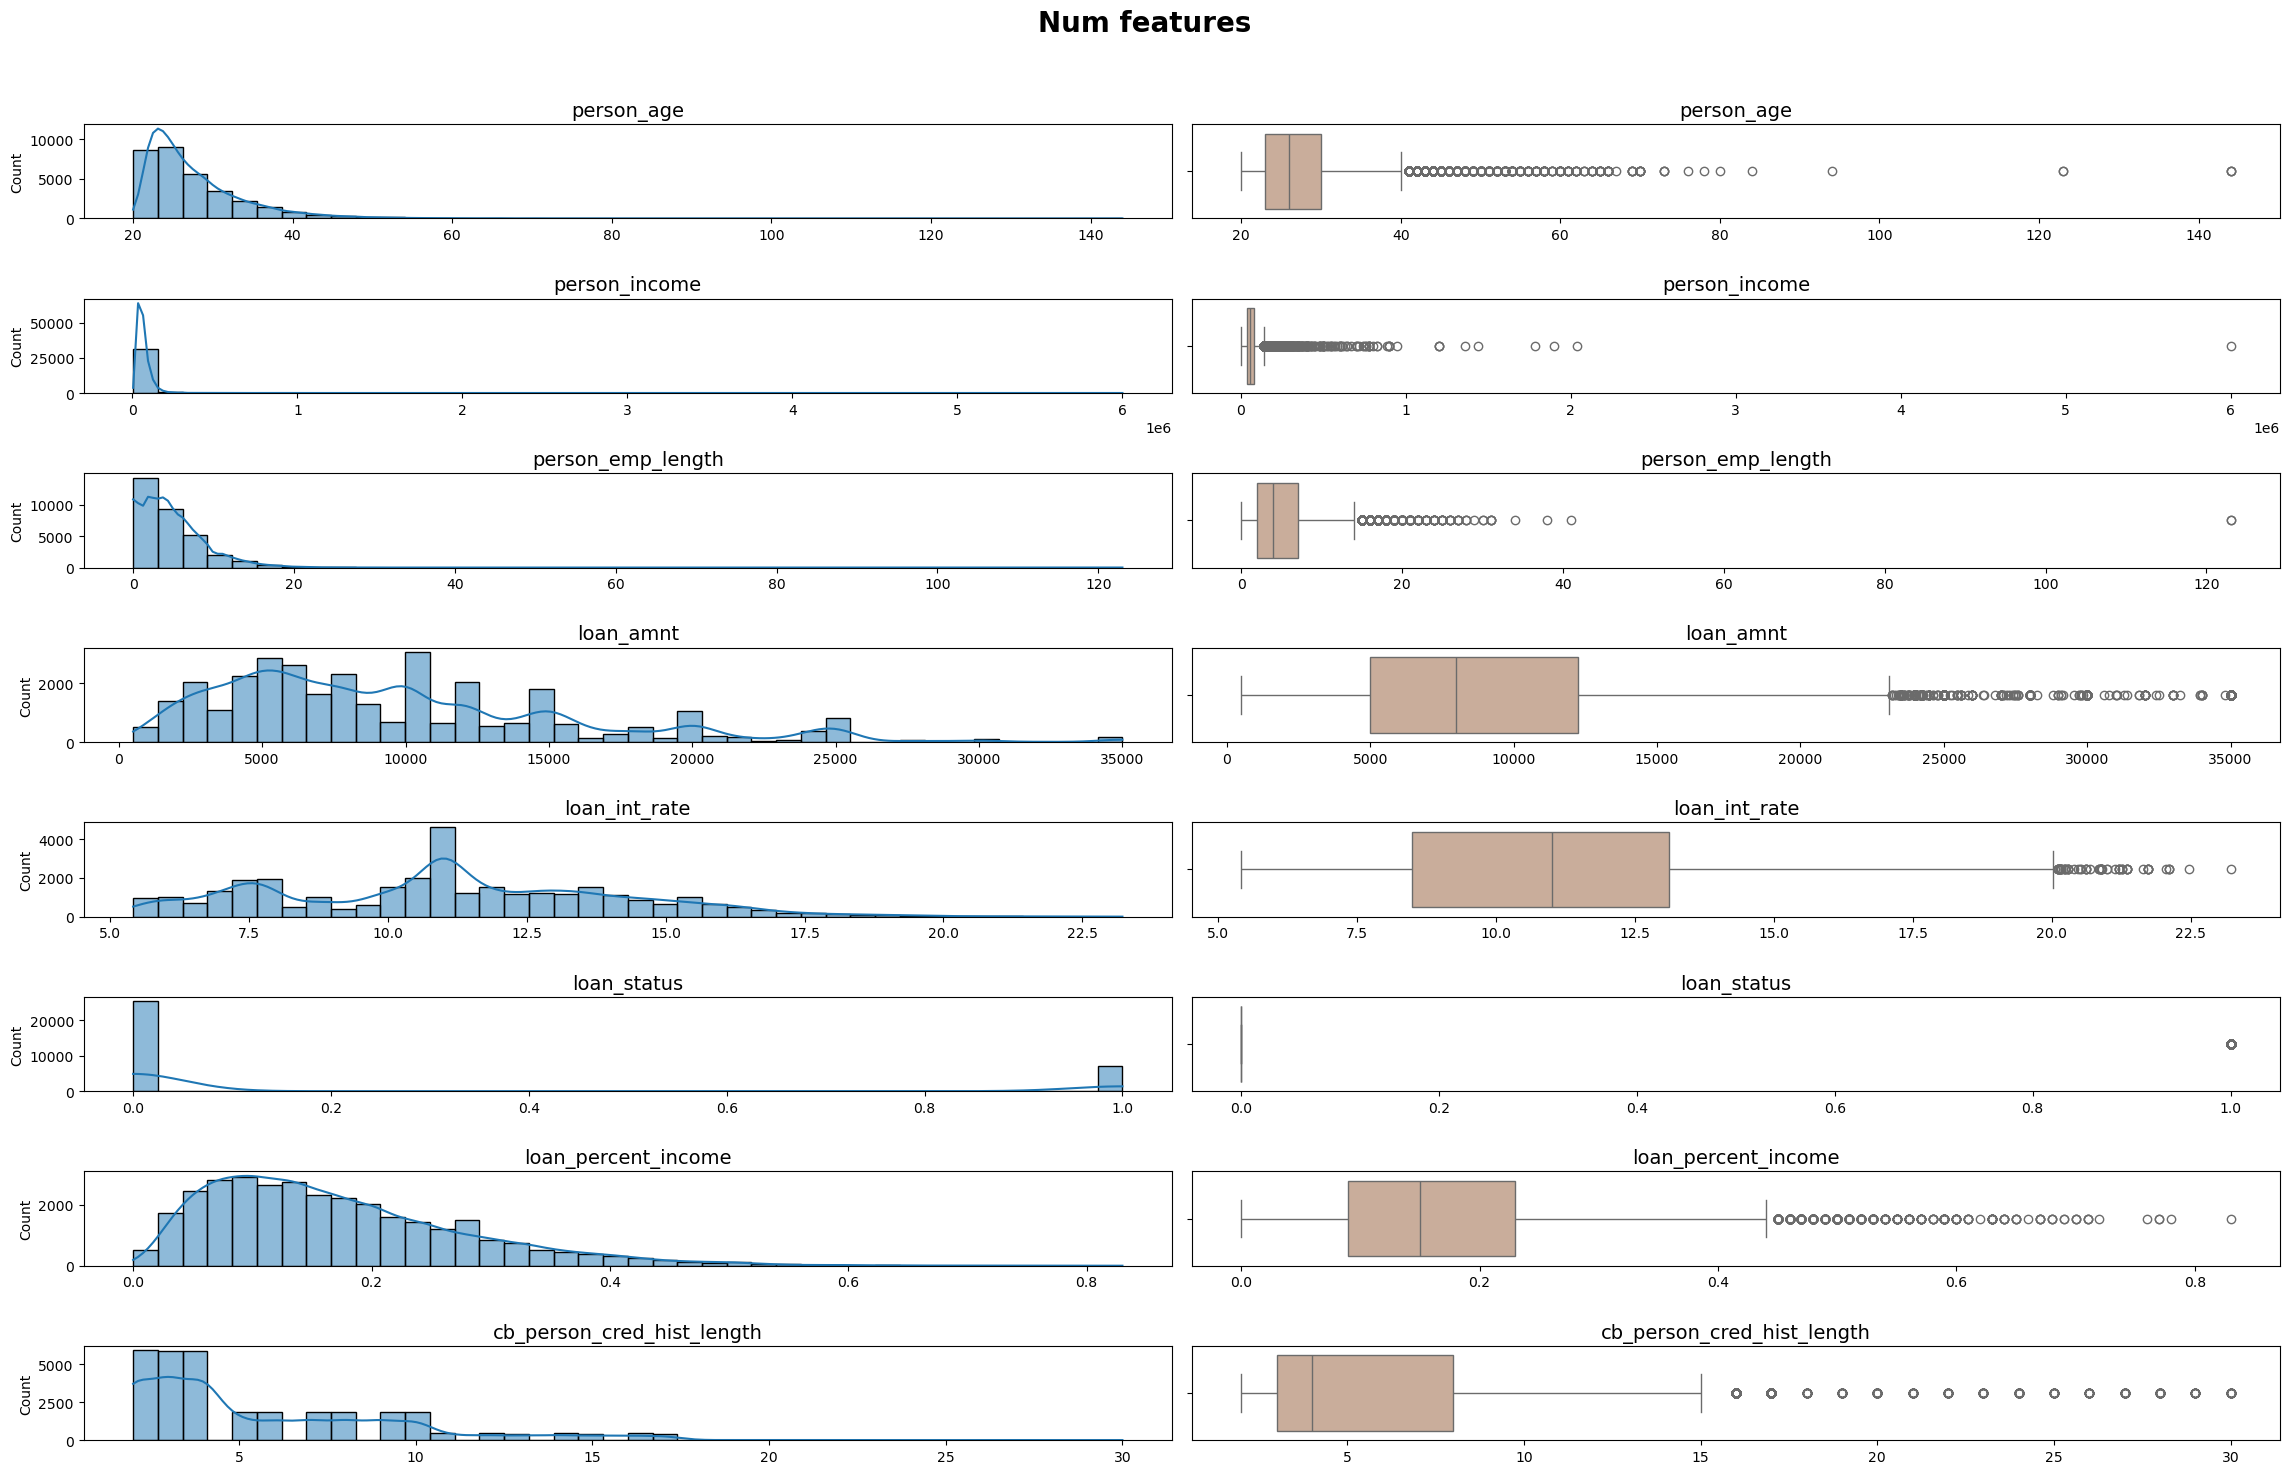

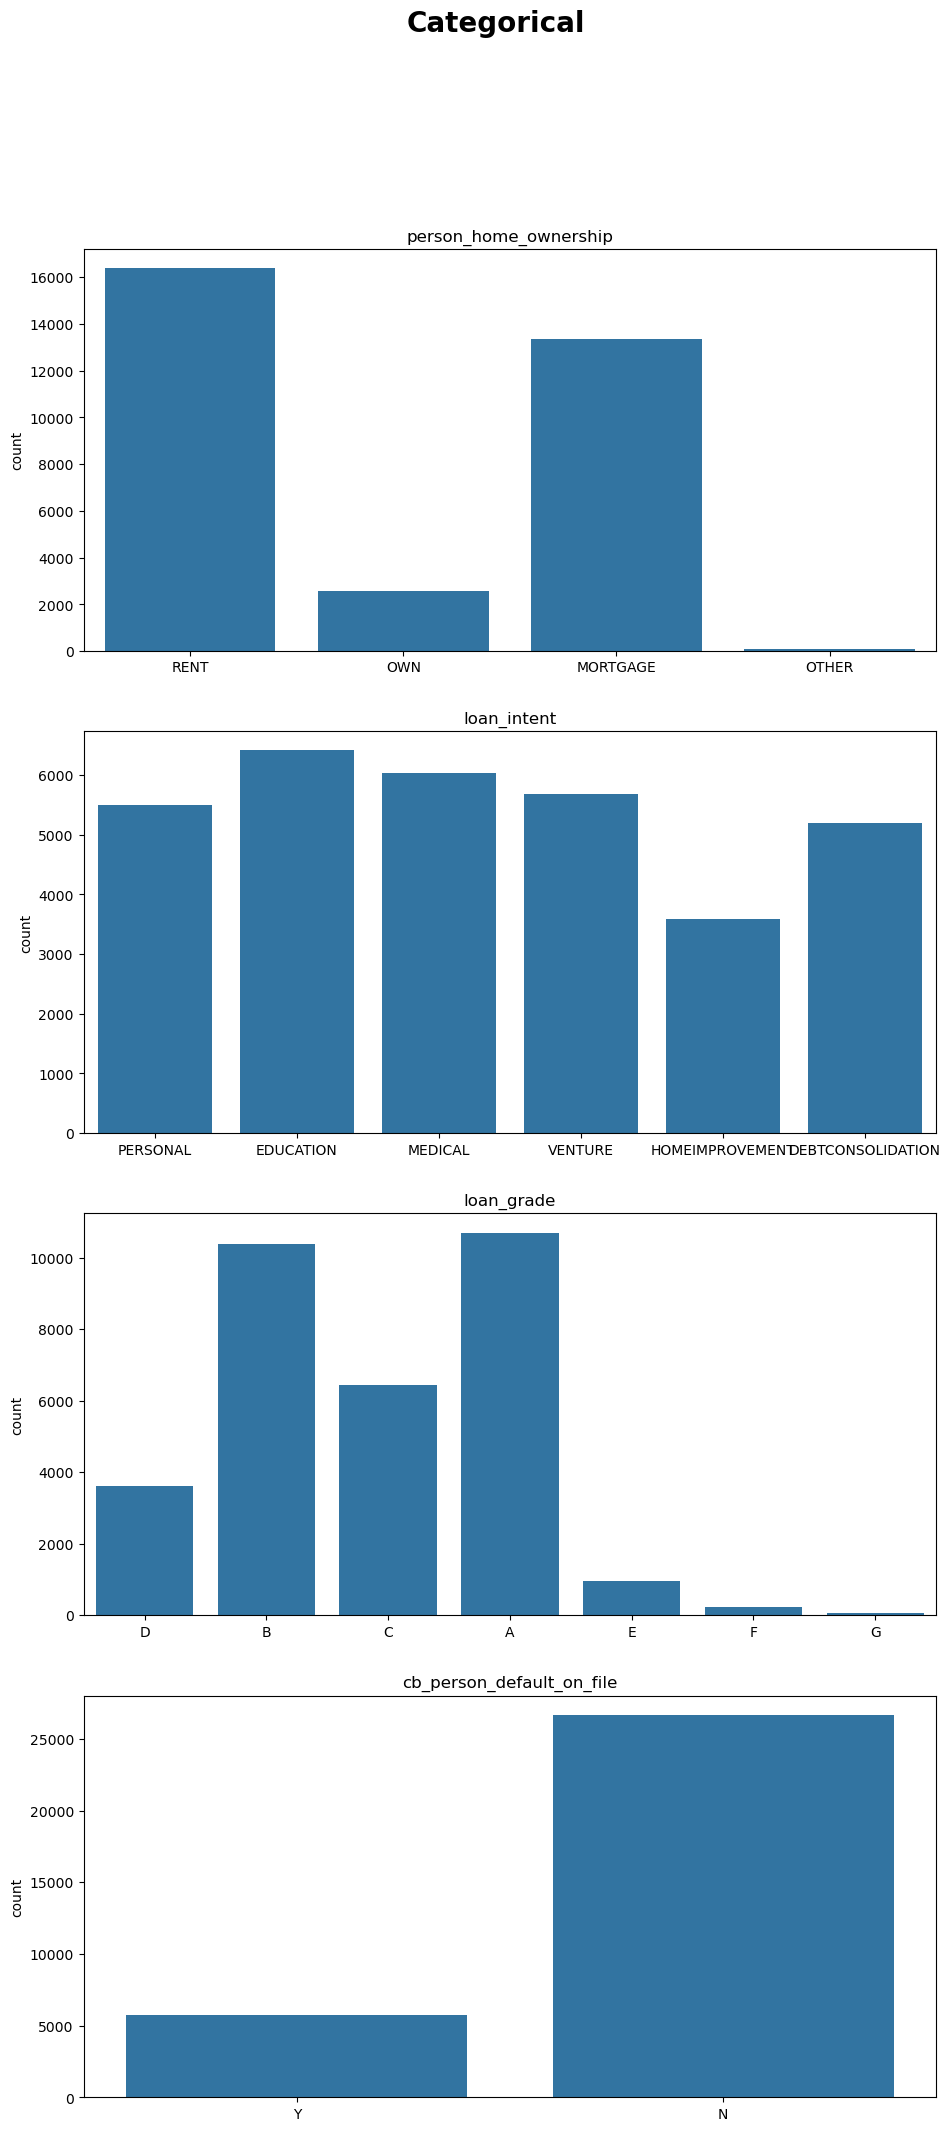

In [128]:
DataAnalysis.view_distribution(train_original, object_col=True, numeric_col=True)

In [129]:
for data in [train_competitions, train_original]:
    DataAnalysis.bloating_of_variance(data)

                      feature        VIF
0                  person_age  35.272224
1               person_income   7.120731
2           person_emp_length   2.530099
3                   loan_amnt  11.712513
4               loan_int_rate  12.477774
5         loan_percent_income  12.472079
6  cb_person_cred_hist_length   8.083912
7                 loan_status   1.498183
                      feature        VIF
0                  person_age  29.394486
1               person_income   3.196920
2           person_emp_length   2.485441
3                   loan_amnt   7.085949
4               loan_int_rate  12.165984
5                 loan_status   1.667190
6         loan_percent_income   7.941370
7  cb_person_cred_hist_length   7.488644


In [105]:
# train_competitions = train_competitions.drop(['person_age'], axis=1)
# train_original = train_original.drop(['person_age'], axis=1)
# test_competitions = test_competitions.drop(['person_age'], axis=1)

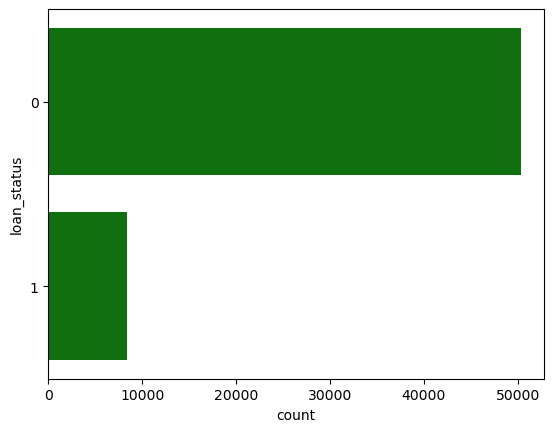

In [130]:
sns.countplot(y=CFG.TARGET, data=train_competitions, color='green');

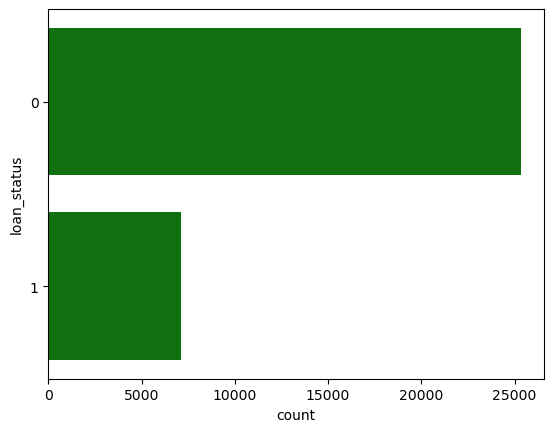

In [131]:
sns.countplot(y=CFG.TARGET, data=train_original, color='green');

In [132]:
train_competitions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [133]:
train_competitions['cb_person_default_on_file'].unique()

array(['N', 'Y'], dtype=object)

In [134]:
class DataLoader:
    def __init__(self, train_c: pd.DataFrame, train_o: pd.DataFrame, test: pd.DataFrame):
        self.train_c = train_c
        self.train_o = train_o
        self.test = test

    @staticmethod
    def encode_categorical_features(dataframe):  
        print('--- Encoding categorical features')
        
        person_home_ownership = {'RENT': 0, 'OWN': 1, 'MORTGAGE': 2, 'OTHER': 3}
        loan_intent = {'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}
        loan_grade = {'B': 0, 'C': 1, 'A': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
        cb_person_default_on_file = {'N': 0, 'Y': 1}
        
        dataframe['person_home_ownership'] = dataframe['person_home_ownership'].map(person_home_ownership)
        dataframe['loan_intent'] = dataframe['loan_intent'].map(loan_intent)
        dataframe['loan_grade'] = dataframe['loan_grade'].map(loan_grade)
        dataframe['cb_person_default_on_file'] = dataframe['cb_person_default_on_file'].map(cb_person_default_on_file)
        
        return dataframe
    
    @staticmethod
    def add_features(dataframe):  
        print('--- Adding new features')
        # Reference: https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution
        # Beware of data leakage
        dataframe['Previously_Insured_person_amnt'] = pd.factorize(dataframe['person_income'].astype(str) + dataframe['loan_amnt'].astype(str))[0]
        
        return dataframe
    
    @staticmethod
    def reduce_mem_usage(dataframe):
        # Reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516103#2899151
        
        print('--- Reducing memory usage')
        initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
        
        for col in dataframe.columns:
            col_type = dataframe[col].dtype

            if col_type.name in ['category', 'object']:
                raise ValueError(f"Column '{col}' is of type '{col_type.name}'")

            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)

        final_mem_usage = dataframe.memory_usage().sum() / 1024**2
        print('------ Memory usage before: {:.2f} MB'.format(initial_mem_usage))
        print('------ Memory usage after: {:.2f} MB'.format(final_mem_usage))
        print('------ Decreased memory usage by {:.1f}%'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

        return dataframe

    def load(self):
        print(f'Loading data')
        
        train_c = self.train_c
        train_o = self.train_o
        test = self.test

        train = pd.concat([train_c, train_o]).reset_index(drop=True)
        
        train['is_train'] = 1
        test['is_train'] = 0
        dataframe = pd.concat([train, test])
        del train, test
        gc.collect()
        
        dataframe = self.encode_categorical_features(dataframe)
        # dataframe = self.convert_data_types(dataframe)
        # dataframe = self.add_features(dataframe)
        dataframe = self.reduce_mem_usage(dataframe)
        
        train = dataframe[dataframe['is_train'] == 1].drop(columns=['is_train'])
        test = dataframe[dataframe['is_train'] == 0].drop(columns=['is_train', CFG.TARGET])
        
        del dataframe
        gc.collect()
        
        train[CFG.TARGET] = train[CFG.TARGET].astype(np.int8)
        
        return train, test

In [135]:
train, test = DataLoader(train_competitions,train_original,test_competitions).load()

Loading data
--- Encoding categorical features
--- Reducing memory usage
------ Memory usage before: 13.90 MB
------ Memory usage after: 3.97 MB
------ Decreased memory usage by 71.4%


In [136]:
X = train.drop(columns=CFG.TARGET)
y = train[CFG.TARGET]

In [137]:
def build_catboost(trial):
    params = {
        'iterations': 100,
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', .1, 1., log=True),
        'random_strength': trial.suggest_float('random_strength', .1, 1., log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', .1, 1., log=True),
        'bootstrap_type':'Bayesian',
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'task_type': 'GPU',
    }


    model = CatBoostClassifier(**params, silent=True, random_state=CFG.RANDOM_STATE)
    cv_data = cv(
        Pool(X, y),
        model.get_params(),
        verbose=False
    )
    return np.mean(cv_data['test-AUC-mean'])

In [138]:
study = optuna.create_study(direction="maximize")
study.optimize(build_catboost, n_trials=CFG.N_FOLDS)

[I 2024-10-19 00:30:20,982] A new study created in memory with name: no-name-90165df9-fa02-49c7-8f0a-d63e1d9aa8a6
Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/3]
bestTest = 0.8940482438
bestIteration = 95
Training on fold [1/3]
bestTest = 0.9042551816
bestIteration = 45
Training on fold [2/3]


[I 2024-10-19 00:30:38,632] Trial 0 finished with value: 0.8967285619841681 and parameters: {'learning_rate': 0.000502457023679206, 'depth': 7, 'l2_leaf_reg': 0.2233636981068539, 'random_strength': 0.37023862296493854, 'bagging_temperature': 0.1641278889399914}. Best is trial 0 with value: 0.8967285619841681.


bestTest = 0.8977216482
bestIteration = 20


Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/3]
bestTest = 0.8813657165
bestIteration = 45
Training on fold [1/3]
bestTest = 0.8939406872
bestIteration = 99
Training on fold [2/3]


[I 2024-10-19 00:30:49,430] Trial 1 finished with value: 0.8869420682627058 and parameters: {'learning_rate': 0.00013429549193005904, 'depth': 6, 'l2_leaf_reg': 0.11937293950369955, 'random_strength': 0.1108328130663182, 'bagging_temperature': 0.2935044789948976}. Best is trial 0 with value: 0.8967285619841681.


bestTest = 0.8877805471
bestIteration = 70


Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/3]
bestTest = 0.820948422
bestIteration = 5
Training on fold [1/3]
bestTest = 0.6781968623
bestIteration = 0
Training on fold [2/3]


[I 2024-10-19 00:30:56,609] Trial 2 finished with value: 0.7264572817181785 and parameters: {'learning_rate': 0.00018687545366506114, 'depth': 1, 'l2_leaf_reg': 0.11835098999805413, 'random_strength': 0.731310751046734, 'bagging_temperature': 0.7801641054501749}. Best is trial 0 with value: 0.8967285619841681.


bestTest = 0.8231214285
bestIteration = 95


Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/3]
bestTest = 0.9094643295
bestIteration = 99
Training on fold [1/3]
bestTest = 0.9161713123
bestIteration = 99
Training on fold [2/3]


[I 2024-10-19 00:31:04,070] Trial 3 finished with value: 0.8962608055462912 and parameters: {'learning_rate': 0.035577152130558114, 'depth': 3, 'l2_leaf_reg': 0.10716412689638122, 'random_strength': 0.1805328613639831, 'bagging_temperature': 0.12748010658422249}. Best is trial 0 with value: 0.8967285619841681.


bestTest = 0.9113528132
bestIteration = 99


Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/3]
bestTest = 0.9045725465
bestIteration = 60
Training on fold [1/3]
bestTest = 0.912751615
bestIteration = 99
Training on fold [2/3]


[I 2024-10-19 00:31:55,568] Trial 4 finished with value: 0.9071929014864422 and parameters: {'learning_rate': 0.00024652627617606656, 'depth': 9, 'l2_leaf_reg': 0.1655721210590504, 'random_strength': 0.3805091193111387, 'bagging_temperature': 0.12371741762169389}. Best is trial 4 with value: 0.9071929014864422.


bestTest = 0.9078298211
bestIteration = 85


In [139]:
print('Best hyperparameters:', study.best_params)
print('Best AUC-ROC:', study.best_value)

Best hyperparameters: {'learning_rate': 0.00024652627617606656, 'depth': 9, 'l2_leaf_reg': 0.1655721210590504, 'random_strength': 0.3805091193111387, 'bagging_temperature': 0.12371741762169389}
Best AUC-ROC: 0.9071929014864422


In [140]:
aucs = []
preds = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG.RANDOM_STATE)

for CFG.N_FOLDS, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f'### Fold {CFG.N_FOLDS+1} Training ###')
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_valid = X.iloc[valid_idx]
    y_valid = y.iloc[valid_idx]
    X_test = test[X.columns]

    X_train_pool = Pool(X_train, y_train)
    X_valid_pool = Pool(X_valid, y_valid)
    X_test_pool = Pool(X_test)
    
    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        learning_rate=0.00024652627617606656,
        iterations=10000,
        depth=9,
        l2_leaf_reg=0.1655721210590504,
        random_strength=0.3805091193111387,
        bagging_temperature=0.12371741762169389,
        bootstrap_type='Bayesian',
        task_type='GPU',
        random_seed=CFG.RANDOM_STATE,
        verbose=False
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=500, early_stopping_rounds=200)

    pred_valid = model.predict_proba(X_valid_pool)[:, 1]
    preds.append(model.predict_proba(X_test_pool)[:, 1])

    auc = roc_auc_score(y_valid, pred_valid)
    aucs.append(auc)

    print(f'Fold {CFG.N_FOLDS+1} AUC: {auc:.5f}\n')

print(f'\nOverall AUC: {np.mean(aucs):.5f} +/- {np.std(aucs):.5f}')

### Fold 1 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9007257	best: 0.9007257 (0)	total: 11.6ms	remaining: 1m 55s
500:	test: 0.9092003	best: 0.9100110 (324)	total: 5.17s	remaining: 1m 38s
bestTest = 0.9100109637
bestIteration = 324
Shrink model to first 325 iterations.
Fold 1 AUC: 0.91001

### Fold 2 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9017214	best: 0.9017214 (0)	total: 10.1ms	remaining: 1m 41s
bestTest = 0.9094412327
bestIteration = 80
Shrink model to first 81 iterations.
Fold 2 AUC: 0.90944

### Fold 3 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8992281	best: 0.8992281 (0)	total: 10.9ms	remaining: 1m 49s
bestTest = 0.9072513878
bestIteration = 99
Shrink model to first 100 iterations.
Fold 3 AUC: 0.90725

### Fold 4 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9015501	best: 0.9015501 (0)	total: 10.1ms	remaining: 1m 41s
500:	test: 0.9092258	best: 0.9093466 (333)	total: 5.12s	remaining: 1m 37s
bestTest = 0.9093465507
bestIteration = 333
Shrink model to first 334 iterations.
Fold 4 AUC: 0.90935

### Fold 5 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9034560	best: 0.9034560 (0)	total: 10.4ms	remaining: 1m 44s
bestTest = 0.9121799767
bestIteration = 71
Shrink model to first 72 iterations.
Fold 5 AUC: 0.91218


Overall AUC: 0.90965 +/- 0.00158


In [141]:
submission = submission[['id']]
submission['loan_status'] = np.mean(preds, axis=0)

submission.to_csv('submission.csv', index=False)
submission

,id,loan_status
0,58645,0.551099
1,58646,0.460018
2,58647,0.495011
3,58648,0.467111
4,58649,0.482710
...,...,...
39093,97738,0.473045
39094,97739,0.466743
39095,97740,0.460375
39096,97741,0.492434
